In [279]:
# Author: Soumedhik Bharati

# This script captures a specified number of images from a live camera feed, performs data augmentation on these images 
# using Albumentations library, creates training, testing, and validation datasets, builds a custom face tracking model 
# using TensorFlow/Keras, and utilizes the VGG16 pre-trained model for feature extraction.


In [278]:
import os
import tensorflow as tf
import uuid
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import json

In [146]:
IMAGES_PATH = os.path.join('data','images')
number_images = 100

In [149]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image{}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [159]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [160]:
images = tf.data.Dataset.list_files('data\images\*.jpg', shuffle= True)

In [161]:
images.as_numpy_iterator().next()

b'data\\images\\db3b4a97-8144-11ee-9918-c65db183971d.jpg'

In [162]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [163]:
images = images.map(load_images)

In [164]:
images.as_numpy_iterator().next()

array([[[ 68,  68,  60],
        [ 61,  61,  53],
        [ 66,  65,  60],
        ...,
        [ 40,  26,  26],
        [ 37,  25,  27],
        [ 41,  29,  31]],

       [[ 70,  69,  64],
        [ 63,  62,  57],
        [ 65,  64,  59],
        ...,
        [ 43,  27,  28],
        [ 39,  24,  27],
        [ 38,  23,  26]],

       [[ 73,  69,  68],
        [ 67,  63,  62],
        [ 67,  63,  62],
        ...,
        [ 45,  24,  29],
        [ 44,  25,  29],
        [ 44,  25,  29]],

       ...,

       [[ 92,  41,  72],
        [ 95,  45,  74],
        [ 99,  48,  79],
        ...,
        [ 64,  63,  59],
        [ 51,  50,  46],
        [ 48,  47,  43]],

       [[ 92,  43,  75],
        [ 95,  46,  76],
        [100,  51,  83],
        ...,
        [ 57,  53,  50],
        [ 56,  52,  49],
        [ 54,  50,  47]],

       [[ 90,  43,  75],
        [ 90,  43,  75],
        [ 94,  47,  79],
        ...,
        [ 58,  54,  51],
        [ 58,  54,  51],
        [ 62,  58,  55]]

In [165]:
image_generator = images.batch(2).as_numpy_iterator()

In [166]:
plot_images = image_generator.next()

In [167]:
#fig, ax = plt.subplots(ncols = 2, figsize = (20,20))
#for idx, image in enumerate(plot_images):
#   ax[idx].imshow(image)
#plt.show()

In [168]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

In [205]:
import albumentations as alb

In [206]:
augmentor = alb.Compose(
    [
        alb.RandomCrop(width=450, height=450),
        alb.HorizontalFlip(p=0.5),
        alb.RandomBrightnessContrast(p=0.2),
        alb.RandomGamma(p=0.2),
        alb.RGBShift(p=0.2),
        alb.VerticalFlip(p=0.5),
    ],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)


In [207]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'db3b4a97-8144-11ee-9918-c65db183971d.jpg'))

In [208]:
img

array([[[253, 255, 254],
        [253, 255, 254],
        [255, 255, 254],
        ...,
        [114, 128, 104],
        [113, 130, 103],
        [114, 132, 103]],

       [[254, 254, 254],
        [254, 255, 253],
        [255, 253, 253],
        ...,
        [113, 129, 106],
        [114, 130, 106],
        [115, 132, 105]],

       [[255, 254, 255],
        [255, 255, 255],
        [255, 254, 255],
        ...,
        [114, 129, 108],
        [115, 131, 108],
        [114, 132, 109]],

       ...,

       [[ 93,  58, 148],
        [ 93,  58, 148],
        [ 88,  56, 143],
        ...,
        [ 80,  80,  80],
        [ 87,  86,  88],
        [ 88,  87,  89]],

       [[ 95,  65, 154],
        [ 95,  65, 154],
        [ 90,  60, 149],
        ...,
        [ 80,  80,  80],
        [ 87,  86,  88],
        [ 88,  87,  89]],

       [[105,  77, 166],
        [105,  77, 166],
        [ 98,  70, 159],
        ...,
        [ 79,  79,  79],
        [ 85,  84,  86],
        [ 87,  86,  88]]

In [213]:
with open(os.path.join('data', 'train', 'labels', 'db3b4a97-8144-11ee-9918-c65db183971d.json'), 'r')as f:
    label = json.load(f)

In [214]:
print(label['shapes'][0]['label'])
print(label['shapes'][0]['points'])

face
[[197.1276595744681, 151.17021276595747], [335.4255319148936, 321.9148936170213]]


In [215]:
coords = [0,0,0,0]

coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

coords = list(np.divide(coords,[640, 480, 640, 480]))
print(coords)

[0.30801196808510645, 0.3149379432624114, 0.5241023936170213, 0.6706560283687943]


In [216]:
augmented = augmentor(image=img, bboxes=[coords], class_labels = ['face'])

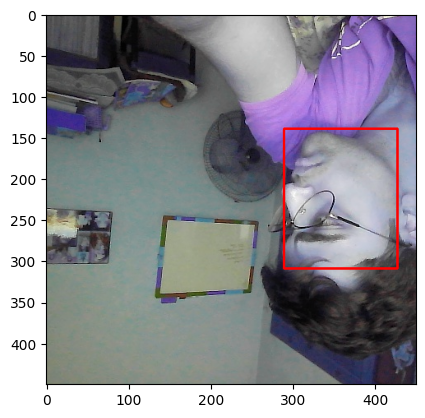

In [217]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
             (255,0,0),2)
plt.imshow(augmented['image'])

In [188]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(120):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [218]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [219]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [220]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [221]:
train_images.as_numpy_iterator().next()

array([[[0.49981618, 0.24338235, 0.2620098 ],
        [0.49669117, 0.24178922, 0.26433823],
        [0.5106005 , 0.2596201 , 0.2601103 ],
        ...,
        [0.39895833, 0.3518995 , 0.30091912],
        [0.40490195, 0.35784313, 0.30686274],
        [0.40281862, 0.3557598 , 0.29791668]],

       [[0.5020221 , 0.2471201 , 0.27064952],
        [0.49969363, 0.2382353 , 0.26397058],
        [0.52077204, 0.26194853, 0.26979166],
        ...,
        [0.40784314, 0.36617646, 0.2882353 ],
        [0.40416667, 0.36384803, 0.28547794],
        [0.40655637, 0.3648897 , 0.28694853]],

       [[0.4935049 , 0.23860294, 0.26213235],
        [0.49822304, 0.24332108, 0.27371323],
        [0.516973  , 0.2581495 , 0.27383578],
        ...,
        [0.37015933, 0.34620097, 0.29632354],
        [0.39522058, 0.37169117, 0.32181373],
        [0.38321078, 0.3598652 , 0.30085784]],

       ...,

       [[0.7053922 , 0.90931374, 0.9642157 ],
        [0.7079044 , 0.91182595, 0.9667279 ],
        [0.7042279 , 0

In [222]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [223]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [224]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [225]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [226]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [227]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(25800, 25800, 4800, 4800, 5280, 5280)

In [228]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(26000)
train = train.batch(8)
train = train.prefetch(4)

In [229]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [230]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [231]:
data_samples = train.as_numpy_iterator()

In [232]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


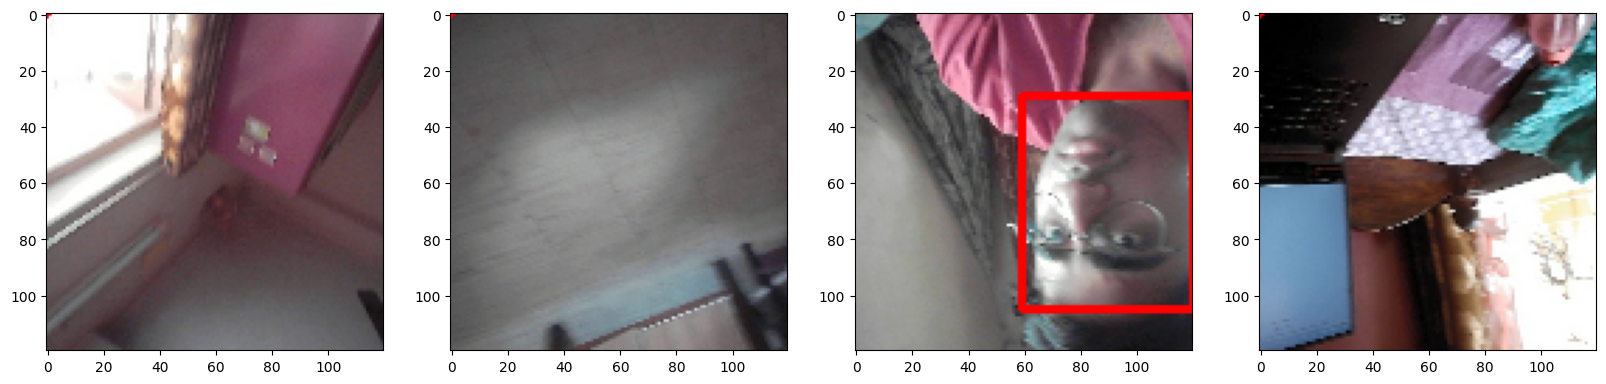

In [233]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [234]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [235]:
vgg = VGG16(include_top=False)

In [236]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [237]:
 def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [238]:
facetracker = build_model()

In [239]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_5[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [240]:
X, y = train.as_numpy_iterator().next()

In [241]:
X.shape

(8, 120, 120, 3)

In [242]:
classes, coords = facetracker.predict(X)

In [243]:
classes, coords

(array([[0.34755042],
        [0.3175067 ],
        [0.35851887],
        [0.33097982],
        [0.25869069],
        [0.20994082],
        [0.42926627],
        [0.29519597]], dtype=float32),
 array([[0.49913996, 0.3346857 , 0.6172407 , 0.5921449 ],
        [0.564784  , 0.36431393, 0.6688069 , 0.62490356],
        [0.4926499 , 0.3849422 , 0.67965657, 0.63409865],
        [0.4228704 , 0.33489835, 0.6635174 , 0.69447637],
        [0.488381  , 0.36190498, 0.6827286 , 0.6902192 ],
        [0.5102429 , 0.3165775 , 0.6216606 , 0.6787414 ],
        [0.54694116, 0.36732015, 0.62087107, 0.6692142 ],
        [0.4679984 , 0.29260162, 0.67954963, 0.63474363]], dtype=float32))

In [244]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [245]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [246]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [247]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [248]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2853394>

In [249]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9014417>

In [250]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2853394>

In [251]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [252]:
model = FaceTracker(facetracker)

In [253]:
model.compile(opt, classloss, regressloss)

In [254]:
logdir='logs'

In [255]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [256]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
3225/3225 [==============================] - 396s 86ms/step - total_loss: 0.1417 - class_loss: 0.0461 - regress_loss: 0.1187 - val_total_loss: 0.0271 - val_class_loss: 0.0027 - val_regress_loss: 0.0257
Epoch 2/40
3225/3225 [==============================] - 363s 86ms/step - total_loss: 0.0532 - class_loss: 0.0207 - regress_loss: 0.0428 - val_total_loss: 0.0832 - val_class_loss: 0.0295 - val_regress_loss: 0.0684
Epoch 3/40
3225/3225 [==============================] - 356s 82ms/step - total_loss: 0.0335 - class_loss: 0.0132 - regress_loss: 0.0269 - val_total_loss: 0.0524 - val_class_loss: 6.9794e-04 - val_regress_loss: 0.0521
Epoch 4/40
3225/3225 [==============================] - 364s 83ms/step - total_loss: 0.0246 - class_loss: 0.0086 - regress_loss: 0.0203 - val_total_loss: 0.0475 - val_class_loss: 3.7153e-05 - val_regress_loss: 0.0474
Epoch 5/40
3225/3225 [==============================] - 359s 80ms/step - total_loss: 0.0151 - class_loss: 0.0052 - regress_loss: 0.0124 - va

Epoch 38/40
3225/3225 [==============================] - 459s 89ms/step - total_loss: 1.0990e-04 - class_loss: 1.6909e-08 - regress_loss: 1.0990e-04 - val_total_loss: 1.3414 - val_class_loss: 1.5347 - val_regress_loss: 0.5740
Epoch 39/40
3225/3225 [==============================] - 445s 89ms/step - total_loss: 9.9909e-05 - class_loss: 9.5593e-09 - regress_loss: 9.9904e-05 - val_total_loss: 1.4309 - val_class_loss: 1.4249 - val_regress_loss: 0.7185
Epoch 40/40
3225/3225 [==============================] - 450s 89ms/step - total_loss: 9.7021e-05 - class_loss: 9.3469e-09 - regress_loss: 9.7016e-05 - val_total_loss: 1.1690 - val_class_loss: 1.1064 - val_regress_loss: 0.6158


In [257]:
hist.history

{'total_loss': [0.010462208651006222,
  0.005282295402139425,
  0.010509069077670574,
  0.007075156085193157,
  0.0024753096513450146,
  0.0008891947218216956,
  0.00315481866709888,
  0.0027756316121667624,
  0.0007360216695815325,
  0.002406161278486252,
  0.0014590342761948705,
  0.001122038927860558,
  0.0011322736972942948,
  0.0006766418227925897,
  0.0006434575188905001,
  0.0014153039082884789,
  0.00042969617061316967,
  0.0006136265001259744,
  0.00031122041400521994,
  0.0006341386470012367,
  5.359626447898336e-05,
  0.0006990547990426421,
  0.00014488230226561427,
  0.00024448419571854174,
  0.00017198632122017443,
  0.0002167485363315791,
  0.0004031208227388561,
  9.668045095168054e-05,
  0.00014630844816565514,
  0.0003295274218544364,
  0.00030453113140538335,
  0.00011414063919801265,
  0.00010800647578435019,
  9.770777251105756e-05,
  0.00011597218690440059,
  0.00012561690527945757,
  7.152640318963677e-05,
  0.00011015690688509494,
  9.547462104819715e-05,
  0.000

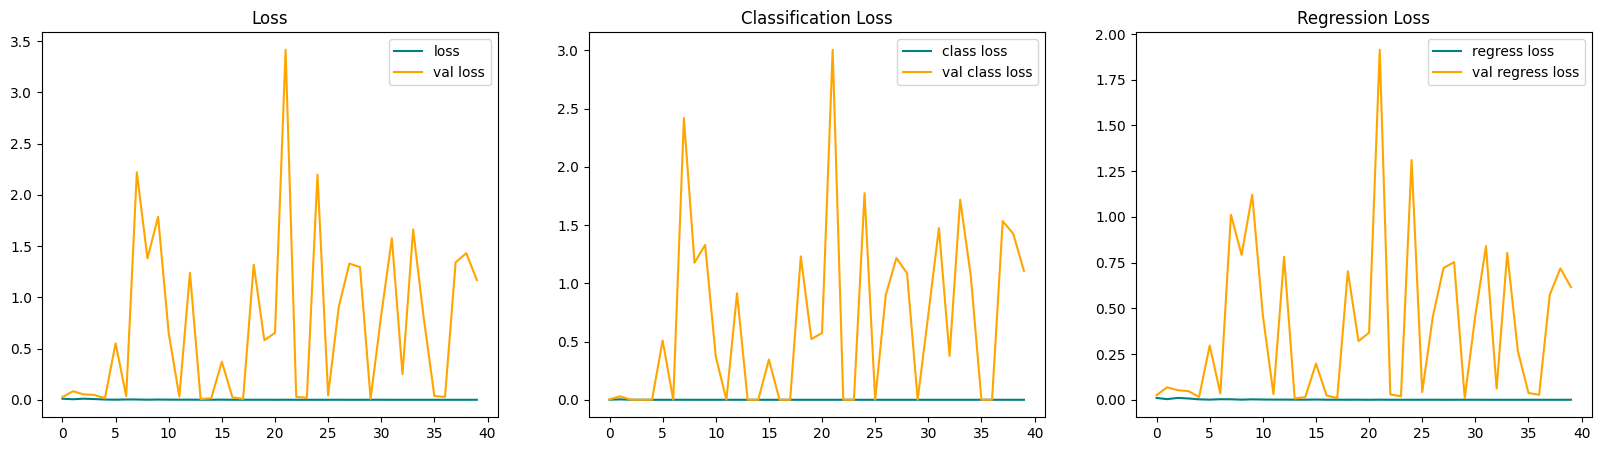

In [258]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [259]:
test_data = test.as_numpy_iterator()

In [266]:
test_sample = test_data.next()

In [267]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


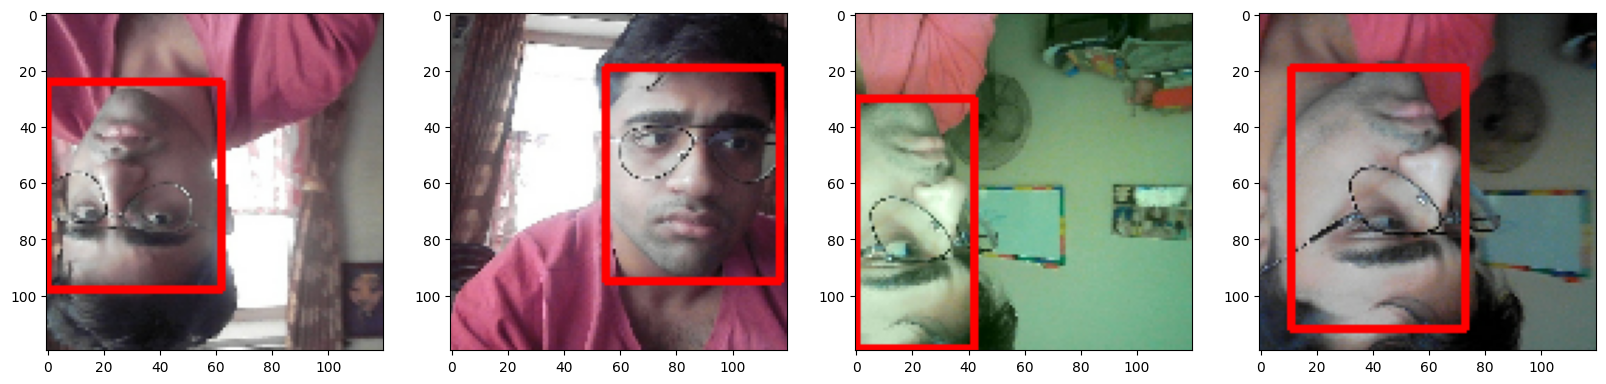

In [268]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [269]:
from tensorflow.keras.models import load_model

In [270]:
facetracker.save('facetracker.h5')

In [271]:
facetracker = load_model('facetracker.h5')

In [276]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()